## 1. Imports
We stick to CPU-friendly libraries (Pillow, NumPy, TorchVision). If something is missing, run `uv sync` from the repo root.

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
from torchvision import datasets, transforms
from torchvision.datasets.utils import download_and_extract_archive

# Resolve repo root so relative paths work even when opened from notebooks/day*
ROOT = Path.cwd().resolve()
while not (ROOT / "pyproject.toml").exists() and ROOT != ROOT.parent:
    ROOT = ROOT.parent
if not (ROOT / "pyproject.toml").exists():
    raise FileNotFoundError("Could not locate repository root containing pyproject.toml")
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
DATA_DIR = ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)
SAMPLE_DIR = DATA_DIR / "samples"
SAMPLE_DIR.mkdir(exist_ok=True)

plt.rcParams['figure.figsize'] = (4, 4)

## 2. Inspect a raw image
Drop in any PNG/JPG here (replace `sample_path`). On fresh clones we default to an MNIST digit from TorchVision.

Image mode: L, dtype: uint8, shape: (803, 1200)


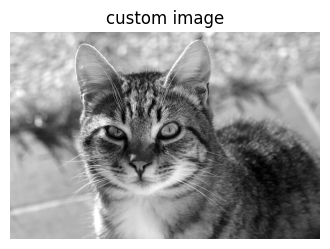

In [2]:
sample_path = DATA_DIR / 'sample_image.jpeg'
if not sample_path.exists():
    mnist = datasets.MNIST(root=DATA_DIR, train=False, download=True)
    img, label = mnist[0]
    sample_path.parent.mkdir(parents=True, exist_ok=True)
    img.save(sample_path)
else:
    img = Image.open(sample_path).convert('L')
    label = None

arr = np.array(img)
print(f'Image mode: {img.mode}, dtype: {arr.dtype}, shape: {arr.shape}')
plt.imshow(arr, cmap='gray');
plt.axis('off');
plt.title(f'label={label}' if label is not None else 'custom image');

> **Tip:** Replace `sample_path` above with any local image (e.g., `ROOT / "data" / "custom" / "ct_scan.png"`). If the path does not exist we default back to MNIST so the workflow always runs.

## 3. Look under the hood (NumPy / tensor views)
Torch models expect tensors shaped `[C, H, W]`. Here we stack and normalize manually before handing tensors to CNNs later.

Tensor shape (C,H,W): (1, 803, 1200)
Value range: (0.0, 1.0)
Mean/std: 0.5395731329917908 0.2434973120689392


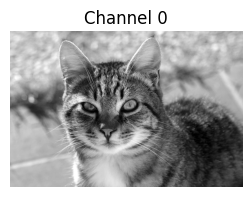

In [3]:
tensor = transforms.ToTensor()(img)
print('Tensor shape (C,H,W):', tuple(tensor.shape))
print('Value range:', (tensor.min().item(), tensor.max().item()))
print('Mean/std:', tensor.mean().item(), tensor.std().item())

fig, axes = plt.subplots(1, tensor.shape[0], figsize=(tensor.shape[0]*3, 3))
if tensor.shape[0] == 1:
    axes = [axes]
for idx, ax in enumerate(axes):
    ax.imshow(tensor[idx].squeeze(), cmap='gray' if tensor.shape[0]==1 else None)
    ax.set_title(f'Channel {idx}')
    ax.axis('off')
plt.show()

In [4]:
tensor

tensor([[[0.7608, 0.7608, 0.7608,  ..., 0.6941, 0.6980, 0.7020],
         [0.7725, 0.7686, 0.7686,  ..., 0.6941, 0.7020, 0.7059],
         [0.7804, 0.7804, 0.7804,  ..., 0.6941, 0.7020, 0.7059],
         ...,
         [0.7373, 0.7373, 0.7373,  ..., 0.0824, 0.0784, 0.0784],
         [0.7373, 0.7373, 0.7373,  ..., 0.0824, 0.0824, 0.0784],
         [0.7373, 0.7373, 0.7373,  ..., 0.0824, 0.0824, 0.0824]]])

## 4. Tour the core datasets
The course toggles between MNIST (warm-up), CIFAR-10 (color images), and COCO-style detection sets. This cell previews a batch from MNIST and CIFAR using TorchVision for consistency.

100%|██████████| 26.4M/26.4M [00:00<00:00, 38.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 2.04MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 31.0MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.79MB/s]


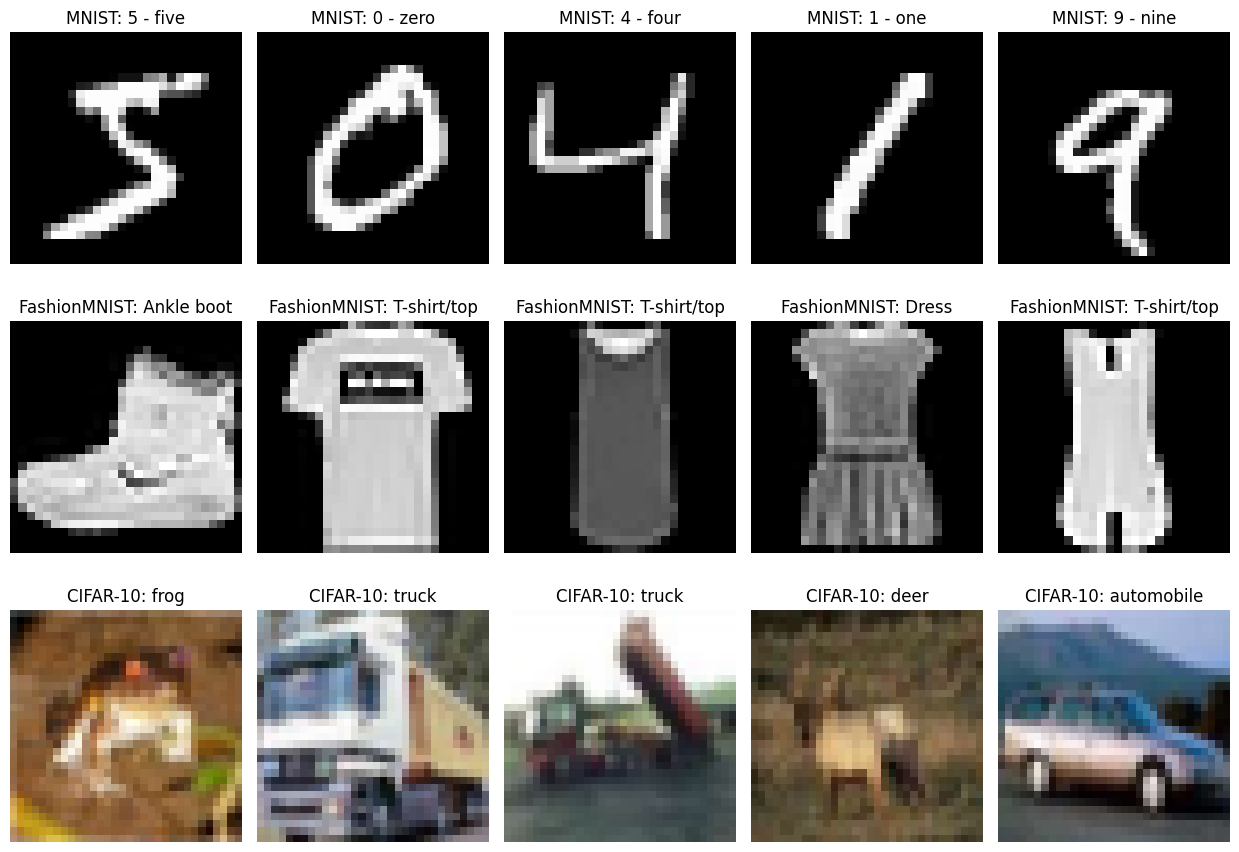

In [5]:
datasets_to_preview = []
datasets_to_preview.append(("MNIST", datasets.MNIST(root=DATA_DIR, train=True, download=True, transform=transforms.ToTensor())))
datasets_to_preview.append(("FashionMNIST", datasets.FashionMNIST(root=DATA_DIR, train=True, download=True, transform=transforms.ToTensor())))
datasets_to_preview.append(("CIFAR-10", datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=transforms.ToTensor())))
imagenet_train_full = DATA_DIR / "imagenet" / "train"
imagenette_train = SAMPLE_DIR / "imagenette2-160" / "train"
if imagenet_train_full.exists():
    datasets_to_preview.append(("ImageNet (local)", datasets.ImageFolder(imagenet_train_full, transform=transforms.ToTensor())))
elif imagenette_train.exists():
    datasets_to_preview.append(("Imagenette mini (ImageNet subset)", datasets.ImageFolder(imagenette_train, transform=transforms.ToTensor())))

def format_label(ds, label):
    if hasattr(ds, "classes") and isinstance(label, int) and 0 <= label < len(ds.classes):
        return ds.classes[label]
    return str(label)

def to_numpy_image(img_tensor):
    if hasattr(img_tensor, "permute"):
        arr = img_tensor.numpy()
        if arr.shape[0] in (1, 3):
            arr = np.transpose(arr, (1, 2, 0))
    elif isinstance(img_tensor, np.ndarray):
        arr = img_tensor
    else:
        arr = np.array(img_tensor)
    if arr.ndim == 2 or (arr.ndim == 3 and arr.shape[2] == 1):
        return arr[..., 0] if arr.ndim == 3 else arr
    return np.clip(arr, 0, 1)

if not datasets_to_preview:
    print("No datasets available yet. Run the download cells below first.")
else:
    cols = 5
    fig, axes = plt.subplots(len(datasets_to_preview), cols, figsize=(cols*2.5, 3*len(datasets_to_preview)))
    if len(datasets_to_preview) == 1:
        axes = np.expand_dims(axes, axis=0)
    for row, (name, ds) in enumerate(datasets_to_preview):
        for col in range(cols):
            img, label = ds[col]
            img_vis = to_numpy_image(img)
            axes[row, col].imshow(img_vis, cmap='gray' if img_vis.ndim == 2 else None)
            axes[row, col].axis('off')
            axes[row, col].set_title(f"{name}: {format_label(ds, label)}")
    plt.tight_layout()

Use this gallery as a quick regression test: confirm grayscale datasets show single-channel tiles, CIFAR images look colorful (and not upside down), and any optional ImageNet rows only appear when their folders exist. If something renders blank, double-check transforms and disk paths before training.

## 6. Dataset Catalog
The table above shows the exact on-disk location for every dataset we reference later. Auto-downloaded sets (MNIST, Fashion, CIFAR) appear under `data/` as soon as you run the preview cells. Heavier corpora (ImageNet, COCO) stay empty until you either place the official files there or pull down the mini versions in the next step. Track availability via the ✅ column.

## 7. Mini versions for the heavyweight datasets
ImageNet and COCO are intentionally kept out of source control because they are huge. Run the next cell to pull down tiny, open-source stand-ins (Imagenette ≈ 130 MB and COCO-128 ≈ 7 MB) into `data/samples/`. You can skip it if you already have the full datasets locally.

In [6]:
DOWNLOAD_MINISETS = True  # flip to False if you already have full datasets locally
imagenette_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz"
coco128_url = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip"
imagenette_dir = SAMPLE_DIR / "imagenette2-160"
coco128_dir = SAMPLE_DIR / "coco128"

def ensure_archive(url: str, target_dir: Path):
    if target_dir.exists():
        print(f"✅ {target_dir.name} already available")
        return target_dir
    print(f"⬇️ Downloading {target_dir.name} ... this can take a minute")
    download_and_extract_archive(url, download_root=SAMPLE_DIR)
    if not target_dir.exists():
        raise FileNotFoundError(f"Expected {target_dir} after extracting {url}")
    print(f"✅ Saved to {target_dir}")
    return target_dir

if DOWNLOAD_MINISETS:
    _ = ensure_archive(imagenette_url, imagenette_dir)
    _ = ensure_archive(coco128_url, coco128_dir)
else:
    print("Skipping downloads. Set DOWNLOAD_MINISETS = True to grab the mini datasets.")

⬇️ Downloading imagenette2-160 ... this can take a minute


100%|██████████| 99.0M/99.0M [00:12<00:00, 7.68MB/s]


✅ Saved to /Users/mishra/LM/projects/computer-vision-cas-hslu-2025/data/samples/imagenette2-160
⬇️ Downloading coco128 ... this can take a minute


100%|██████████| 6.98M/6.98M [00:00<00:00, 13.8MB/s]


✅ Saved to /Users/mishra/LM/projects/computer-vision-cas-hslu-2025/data/samples/coco128


Mini downloads keep demos snappy on student laptops. Rerun this cell whenever you clean the `data/` folder—the helper skips files that already exist, so it is safe to execute multiple times.

## 8. Visual check for every dataset
The classification gallery you ran in Section 4 will now expand automatically when Imagenette is available, and the cell below renders a COCO-style detection batch so every image/label pair is visible before training.

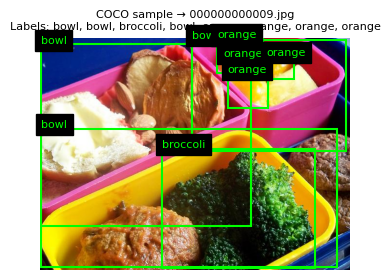

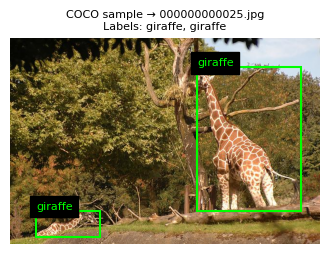

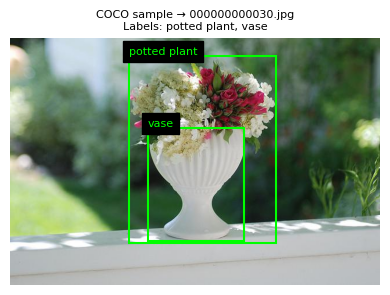

In [7]:
COCO_CLASS_NAMES = [
    "person","bicycle","car","motorcycle","airplane","bus","train","truck","boat","traffic light",
    "fire hydrant","stop sign","parking meter","bench","bird","cat","dog","horse","sheep","cow",
    "elephant","bear","zebra","giraffe","backpack","umbrella","handbag","tie","suitcase","frisbee",
    "skis","snowboard","sports ball","kite","baseball bat","baseball glove","skateboard","surfboard","tennis racket","bottle",
    "wine glass","cup","fork","knife","spoon","bowl","banana","apple","sandwich","orange","broccoli","carrot",
    "hot dog","pizza","donut","cake","chair","couch","potted plant","bed","dining table","toilet","tv","laptop",
    "mouse","remote","keyboard","cell phone","microwave","oven","toaster","sink","refrigerator","book","clock","vase",
    "scissors","teddy bear","hair drier","toothbrush"
]

def show_coco_sample(sample_root: Path, num_images: int = 3):
    image_dir = sample_root / "images" / "train2017"
    label_dir = sample_root / "labels" / "train2017"
    if not image_dir.exists():
        print("COCO sample missing. Run the download cell above or place coco128 under data/samples/.")
        return
    image_paths = sorted(image_dir.glob("*.jpg"))[:num_images]
    if not image_paths:
        print("No images found under", image_dir)
        return
    for image_path in image_paths:
        img = Image.open(image_path).convert("RGB")
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        ax.imshow(img)
        width, height = img.size
        label_file = label_dir / f"{image_path.stem}.txt"
        label_names = []
        if label_file.exists():
            for line in label_file.read_text().strip().splitlines():
                cls_idx, cx, cy, w, h = map(float, line.split())
                box_w, box_h = w * width, h * height
                x0 = (cx - w / 2) * width
                y0 = (cy - h / 2) * height
                rect = patches.Rectangle((x0, y0), box_w, box_h, linewidth=1.5, edgecolor='lime', facecolor='none')
                ax.add_patch(rect)
                cls_idx = int(cls_idx)
                label_name = COCO_CLASS_NAMES[cls_idx] if cls_idx < len(COCO_CLASS_NAMES) else str(cls_idx)
                label_names.append(label_name)
                ax.text(x0, max(y0 - 2, 0), label_name, color='lime', fontsize=8, backgroundcolor='black')
        else:
            label_names.append("<no labels found>")
        ax.axis('off')
        label_summary = ", ".join(label_names)
        ax.set_title(f"COCO sample → {image_path.name}\nLabels: {label_summary}", fontsize=8)
    plt.tight_layout()

show_coco_sample(coco128_dir)

Check that bounding boxes line up with the objects and that label text uses the expected COCO classes. Misaligned boxes usually mean the label files live in the wrong folder or use normalized coordinates different from YOLO format.

In [8]:
id_to_label = {idx: label for idx, label in enumerate(COCO_CLASS_NAMES)}
label_to_id = {label: idx for idx, label in id_to_label.items()}

print("ID to Label Mapping:", id_to_label)
print("Label to ID Mapping:", label_to_id)
id_to_label[58]

ID to Label Mapping: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cel

'potted plant'

Use these dictionaries when you need to translate between YOLO txt files (integer IDs) and human-readable labels inside later detection notebooks. If you customize the COCO class list, regenerate the mappings here to stay consistent.

## 9. Imagenette mini gallery
If you pulled down Imagenette this quick grid shows the same "mini ImageNet" classes we fine-tune on later. Skip the cell if you only have the full ImageNet tree—Section 4 already previews it.

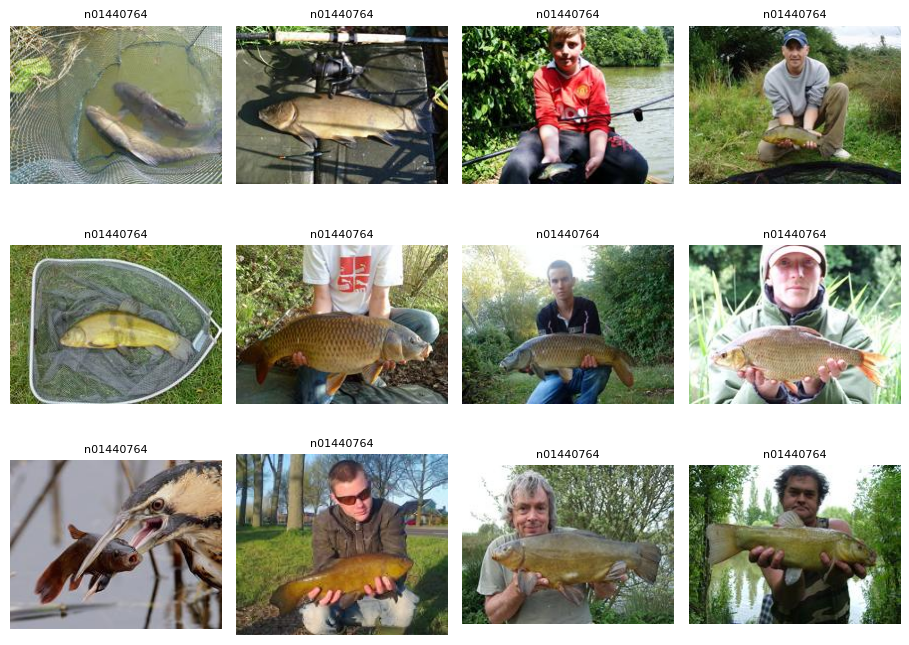

In [9]:
imagenette_train = SAMPLE_DIR / "imagenette2-160" / "train"
if not imagenette_train.exists():
    print("Imagenette mini not found. Run the mini-download cell above or copy it under data/samples/.")
else:
    imagenette_ds = datasets.ImageFolder(imagenette_train, transform=transforms.ToTensor())
    samples = [imagenette_ds[i] for i in range(min(12, len(imagenette_ds)))]
    cols = 4
    rows = int(np.ceil(len(samples) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.3, rows * 2.3))
    axes = axes.flatten()
    for ax, (img, label) in zip(axes, samples):
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        ax.axis('off')
        ax.set_title(imagenette_ds.classes[label], fontsize=8)
    for leftover_ax in axes[len(samples):]:
        leftover_ax.axis('off')
    plt.tight_layout()

Look for balanced coverage of the ten Imagenette classes—if some tiles repeat, it usually means the download was interrupted or the folder permissions prevent TorchVision from reading everything.